In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_2017 = pd.read_csv(r'resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')
df_2017['remaining_lease'] = df_2017['remaining_lease'].str.extract(r'(\d?\d)')
df_2017["remaining_lease"] = pd.to_numeric(df_2017["remaining_lease"])
df_2015 = pd.read_csv(r'resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
df_2012 = pd.read_csv(r'resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
df_2012['remaining_lease'] = 2022 - df_2012['lease_commence_date']
df_2012.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0,36
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0,42
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0,42
3,2012-03,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0,38
4,2012-03,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0,42


In [3]:
lst = [df_2017, df_2015, df_2012]
df = pd.concat(lst)
df.drop('lease_commence_date', axis=1, inplace=True)
df.drop('street_name', axis=1, inplace=True)
df['upper_storey'] = df['storey_range'].str.extract(r'.*(\d\d)$')
df["upper_storey"] = pd.to_numeric(df["upper_storey"])
df.drop('storey_range', axis=1, inplace=True)
df.drop('block', axis=1, inplace=True)
df['month'] = pd.to_datetime(df['month'],infer_datetime_format=True)
df = df.set_index('month')

In [4]:
df.head()

,town,flat_type,floor_area_sqm,flat_model,remaining_lease,resale_price,upper_storey
month,,,,,,,
2017-01-01,ANG MO KIO,2 ROOM,44.0,Improved,61,232000.0,12
2017-01-01,ANG MO KIO,3 ROOM,67.0,New Generation,60,250000.0,3
2017-01-01,ANG MO KIO,3 ROOM,67.0,New Generation,62,262000.0,3
2017-01-01,ANG MO KIO,3 ROOM,68.0,New Generation,62,265000.0,6
2017-01-01,ANG MO KIO,3 ROOM,67.0,New Generation,62,265000.0,3


# Predict Resales Price base on all the numerical variables

In [47]:
# Predict Resales Price base on all the numberical variables
df2 = df[['floor_area_sqm','remaining_lease','resale_price','upper_storey' ]]
df2.head()


,floor_area_sqm,remaining_lease,resale_price,upper_storey
month,,,,
2017-01-01,44.0,61,232000.0,12
2017-01-01,67.0,60,250000.0,3
2017-01-01,67.0,62,262000.0,3
2017-01-01,68.0,62,265000.0,6
2017-01-01,67.0,62,265000.0,3


<AxesSubplot:>

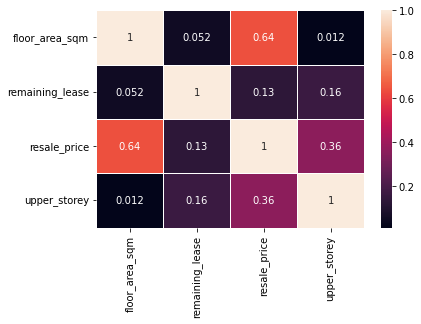

In [147]:
# Correlation for initial 3 numerical variables + our target: HDB resales price
df2.corr()
sns.heatmap(df2.corr(),annot=True,lw=1)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

y = df2[['resale_price']]
X = df2.drop('resale_price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

linreg = LinearRegression().fit(X_train, y_train)

# linreg.score(X_train_scaled, y_train), linreg.score(X_test_scaled, y_test)
print('HDB resale price')
print('linear regression model intercept: {}'
     .format(linreg.intercept_))
print('linear regression model coeff:\n{}'
     .format(linreg.coef_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))
print('Number of features:\n{}'
     .format(len(linreg.coef_[0])))

HDB resale price
linear regression model intercept: [-23569.18962807]
linear regression model coeff:
[[3915.22186549  282.37943854 9253.40369092]]
R-squared score (training): 0.536
R-squared score (test): 0.537
Number of features:
3


### Linear Regression Model give a R-squared score of 0.537 for test data
### let's try to check if we can improve the model by using polynomial features


In [59]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=5)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

linreg_poly = LinearRegression().fit(X_poly_train, y_train)

print('(poly deg 2 + linear) linear model coeff (w):\n{}'
     .format(linreg_poly.coef_))
print('(poly deg 5 + linear) linear model intercept (b):{}'
     .format(linreg_poly.intercept_))
print('(poly deg 5 + linear) R-squared score (training): {:.3f}'
     .format(linreg_poly.score(X_poly_train, y_train)))
print('(poly deg 5 + linear) R-squared score (test): {:.3f}'
     .format(linreg_poly.score(X_poly_test, y_test)))

(poly deg 2 + linear) linear model coeff (w):
[[ 2.33437397e-03  7.44595433e+03 -3.88050216e+04 -3.44334688e+04
   6.34254519e+01 -8.06569671e+02 -1.28696601e+02  1.66519418e+03
   2.98317608e+03  1.52479482e+03  2.07091479e-01 -7.49742237e+00
  -5.71872092e-01  4.45103287e+01  1.47840466e+01 -1.47338383e+01
  -4.88618792e+01 -9.11126762e+01 -7.71400933e+01  2.06957851e+01
  -2.90434838e-03  3.09068650e-02  2.99233228e-02  6.96752730e-02
  -1.10703021e-01 -9.36436614e-02 -7.08226606e-01 -2.15813613e-02
  -2.15288491e-01  1.55446794e+00  6.68557285e-01  1.08513211e+00
   8.56341344e-01  1.46651725e+00 -3.61609092e+00  9.98434916e-06
  -8.50726210e-05 -1.11539535e-04  3.39381968e-05  2.63937916e-04
   2.80590098e-04 -5.01731189e-04 -2.84479920e-05  1.64285867e-03
  -3.29253722e-03  3.75994952e-03 -7.36106886e-05  1.02003993e-03
  -3.19821296e-03 -9.63751690e-03 -3.25118205e-03 -4.31840731e-03
  -5.82827011e-03  1.89195573e-03 -1.51197169e-02  4.66535483e-02]]
(poly deg 5 + linear) linear

### seems like polynomial features have help us improve the model to 0.625, let's try do some prediction

In [60]:
linreg_poly_predict = zip(y_test['resale_price'].head(5), linreg_poly.predict(X_poly_test[0:5]))
print("Resale_Price  Actual Flat Type  Predicted Flat Type")
for i in linreg_poly_predict:
    print(i)

Resale_Price  Actual Flat Type  Predicted Flat Type
(340000.0, array([333234.94990634]))
(545000.0, array([521920.08530148]))
(510000.0, array([535942.28637497]))
(540000.0, array([599205.89031871]))
(778000.0, array([593236.56420312]))


### Let's try to include other categorial variables e.g. location, flat_type and flat_model

In [61]:
# Predict Resales Price base on all the numberical variables

scaler = preprocessing.MinMaxScaler()

# Create Dummy Variables
df_town = pd.get_dummies(df['town'])
df_flat_model = pd.get_dummies(df['flat_model'])
df_flat_type = pd.get_dummies(df['flat_type'])

# Drop duplicated columns
df2 = df.drop('town', axis=1)
df2.drop('flat_model', axis=1, inplace=True)
df2.drop('flat_type', axis=1, inplace=True)

X = pd.concat([df2, df_town, df_flat_model, df_flat_type], axis = 1)
X.head()

,floor_area_sqm,remaining_lease,resale_price,upper_storey,ANG MO KIO,BEDOK,BISHAN,BUKIT BATOK,BUKIT MERAH,BUKIT PANJANG,...,Terrace,Type S1,Type S2,1 ROOM,2 ROOM,3 ROOM,4 ROOM,5 ROOM,EXECUTIVE,MULTI-GENERATION
month,,,,,,,,,,,,,,,,,,,,,
2017-01-01,44.0,61,232000.0,12,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2017-01-01,67.0,60,250000.0,3,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2017-01-01,67.0,62,262000.0,3,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2017-01-01,68.0,62,265000.0,6,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2017-01-01,67.0,62,265000.0,3,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [62]:
y = X[['resale_price']]
X = X.drop('resale_price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linreg = LinearRegression().fit(X_train_scaled, y_train)

# linreg.score(X_train_scaled, y_train), linreg.score(X_test_scaled, y_test)
print('HDB resale price')
print('linear regression model intercept: {}'
     .format(linreg.intercept_))
print('linear regression model coeff:\n{}'
     .format(linreg.coef_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test_scaled, y_test)))
print('Number of features:\n{}'
     .format(len(linreg.coef_[0])))

HDB resale price
linear regression model intercept: [2.94340739e+16]
linear regression model coeff:
[[ 3.16955489e+05  1.12836696e+04  2.64847925e+05  6.01852378e+15
   6.01852378e+15  6.01852378e+15  6.01852378e+15  6.01852378e+15
   6.01852378e+15  6.01852378e+15  6.01852378e+15  6.01852378e+15
   6.01852378e+15  6.01852378e+15  6.01852378e+15  6.01852378e+15
   6.01852378e+15  6.01852378e+15  6.01852378e+15  6.01852378e+15
   6.01852378e+15  6.01852378e+15  6.01852378e+15  6.01852378e+15
   6.01852378e+15  6.01852378e+15  6.01852378e+15  6.01852378e+15
   6.01852378e+15  4.81933990e+15  4.81933990e+15  4.81933990e+15
   4.81933990e+15  4.81933990e+15  4.81933990e+15  4.81933990e+15
   4.81933990e+15  4.81933990e+15  4.81933990e+15  4.81933990e+15
  -1.82620537e+16  4.81933990e+15  4.81933990e+15  4.81933990e+15
   4.81933990e+15  4.81933990e+15  4.81933990e+15  4.81933990e+15
   4.81933990e+15  4.81933990e+15 -4.02719376e+16 -4.02719376e+16
  -4.02719376e+16 -4.02719376e+16 -4.02719

### With Logistics Regression, we achieved a R-squared score of 0.779. Let's try if using Lasso Regression would help us get rid of some of the variables and improve R-squared score (it doesn't make sense to get ridge of individual dummy variables by itself, but it is worth exploring. 

In [50]:
from sklearn.linear_model import Lasso
import warnings
warnings.simplefilter('ignore', UserWarning)
linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train_scaled, y_train)

print('HDB resale price')
print('ridge regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))


HDB resale price
ridge regression linear model intercept: [425730.36445463]
ridge regression linear model coeff:
[ 3.18307379e+05  1.12423616e+04  2.65229548e+05  4.46296893e+04
  2.66141403e+04  1.29066708e+05 -2.41673613e+04  1.57591300e+05
 -6.23389807e+04  2.18249416e+05  1.24094937e+05 -8.63462022e+04
  7.93514802e+04  7.52068363e+04 -1.47685827e+04 -1.07481966e+04
 -6.89746619e+04  9.54805076e+04  1.65940654e+05 -3.44881698e+04
 -2.33622475e+04  1.60598692e+05 -9.95967334e+04 -4.51850326e+04
  4.82659687e+04 -2.46706369e+00  7.48509643e+04 -8.01765764e+04
 -4.06617080e+04 -1.96845773e+03  0.00000000e+00 -4.87395322e+04
 -2.46815915e+04  9.90322597e+04 -1.29603769e+05  2.46344162e+04
  0.00000000e+00 -6.10915541e+04  3.03818586e+03 -8.58128040e+04
  1.30125166e+05 -1.09720019e+05 -5.94171710e+04  1.38296285e+05
  6.77376877e+03 -1.15042417e+05 -1.75119024e+05  2.92983220e+05
  1.66172987e+05  1.74363441e+05 -2.72868173e+05 -1.55163559e+05
 -1.02834383e+05 -1.45616964e+04  9.241640

###  Lasso did variables selction and set 2 variables to 0, however, it didnt help to improve R-square score. 


### Let's use the logistics regression to do some prediction

In [67]:
linreg_predict = zip(y_test['resale_price'].tail(5), linreg.predict(X_test_scaled[-5:]))
print("Actual Resale_Price  Predicted Resales Price")
for i in linreg_predict:
    print(i)

Actual Resale_Price  Predicted Resales Price
(988000.0, array([992816.]))
(350000.0, array([484720.]))
(450000.0, array([595264.]))
(275000.0, array([261768.]))
(315000.0, array([300068.]))


# Classification Model
### let's see how to use the data with dummies categorical variables to come out with a classifcation model
Target = Flat Type (how many rooms / exec HDB)

In [70]:
# Create Dummy Variables
df_town = pd.get_dummies(df['town'])
df_flat_model = pd.get_dummies(df['flat_model'])

# Drop duplicated columns
df3 = df.drop('town', axis=1)
df3.drop('flat_model', axis=1, inplace=True)

X = pd.concat([df3, df_town, df_flat_model], axis = 1)

y = df3[['flat_type']]
X = df3.drop('flat_type', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Let's try using Dummy Classifier, see what would be the test score

In [73]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train)

dummy_stratified = DummyClassifier(strategy = 'stratified').fit(X_train_scaled, y_train)

print('dummy majority R-squared score (training): {:.3f}'
     .format(dummy_majority.score(X_train_scaled, y_train)))
print('dummy majority R-squared score (test): {:.3f}'
     .format(dummy_majority.score(X_test_scaled, y_test)))

print('dummy stratified R-squared score (training): {:.3f}'
     .format(dummy_stratified.score(X_train_scaled, y_train)))
print('dummy stratified R-squared score (test): {:.3f}'
     .format(dummy_stratified.score(X_test_scaled, y_test)))


dummy majority R-squared score (training): 0.408
dummy majority R-squared score (test): 0.411
dummy stratified R-squared score (training): 0.296
dummy stratified R-squared score (test): 0.296


### First using Naive Bayesian

In [74]:
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.simplefilter('ignore', UserWarning)

nbclf = GaussianNB().fit(X_train_scaled, y_train)

print('Naive Bayes Classifier R-squared score (training): {:.3f}'
     .format(nbclf.score(X_train_scaled, y_train)))
print('Naive Bayes Classifier R-squared score (test): {:.3f}'
     .format(nbclf.score(X_test_scaled, y_test)))

Naive Bayes Classifier R-squared score (training): 0.943
Naive Bayes Classifier R-squared score (test): 0.946


Let's try to predict something

In [75]:
X_test_scaled[0:5]

array([[0.14859438, 0.35632184, 0.15649452, 0.        ],
       [0.37349398, 0.81609195, 0.31690141, 0.125     ],
       [0.36144578, 0.64367816, 0.28951487, 0.125     ],
       [0.45381526, 0.79310345, 0.31298905, 0.0625    ],
       [0.31726908, 0.7816092 , 0.49921753, 0.375     ]])

In [78]:
# Get attribute from Test data: 
nbclf_predict = zip(X_test['resale_price'].head(5), y_test['flat_type'].head(5), nbclf.predict(X_test_scaled[0:5]))
print("(Resale_Price,  Actual Type,  Predicted Type)")
for i in nbclf_predict:
    print(i)

(Resale_Price,  Actual Type,  Predicted Type)
(340000.0, '3 ROOM', '3 ROOM')
(545000.0, '5 ROOM', '5 ROOM')
(510000.0, '5 ROOM', '5 ROOM')
(540000.0, 'EXECUTIVE', 'EXECUTIVE')
(778000.0, '5 ROOM', '5 ROOM')


### Let's try Neural Network

In [77]:
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(hidden_layer_sizes = [1,100], solver='lbfgs', random_state = 0).fit(X_train_scaled, y_train)

print('MLPClassifier R-squared score (training): {:.3f}'
     .format(nnclf.score(X_train_scaled, y_train)))
print('MLPClassifier R-squared score (test): {:.3f}'
     .format(nnclf.score(X_test_scaled, y_test)))
# nnclf.score(X_train_scaled, y_train) , nnclf.score(X_test_scaled, y_test)

MLPClassifier R-squared score (training): 0.948
MLPClassifier R-squared score (test): 0.951


In [79]:
nnclf_prediction = zip(X_test['resale_price'].head(20), y_test['flat_type'].head(20), nnclf.predict(X_test_scaled[0:20]))
print("(Resale_Price,  Actual Type,  Predicted Type)")
for i in nnclf_prediction:
    print(i)

(Resale_Price,  Actual Type,  Predicted Type)
(340000.0, '3 ROOM', '3 ROOM')
(545000.0, '5 ROOM', '5 ROOM')
(510000.0, '5 ROOM', '5 ROOM')
(540000.0, 'EXECUTIVE', 'EXECUTIVE')
(778000.0, '5 ROOM', '5 ROOM')
(449000.0, '4 ROOM', '4 ROOM')
(368000.0, '4 ROOM', '4 ROOM')
(345000.0, '4 ROOM', '4 ROOM')
(335000.0, '3 ROOM', '3 ROOM')
(698000.0, '5 ROOM', '5 ROOM')
(449000.0, '5 ROOM', '5 ROOM')
(375000.0, '4 ROOM', '4 ROOM')
(415000.0, '4 ROOM', '4 ROOM')
(760000.0, 'EXECUTIVE', 'EXECUTIVE')
(330000.0, '3 ROOM', '3 ROOM')
(421000.0, '5 ROOM', '5 ROOM')
(450000.0, '4 ROOM', '4 ROOM')
(648000.0, 'EXECUTIVE', 'EXECUTIVE')
(458000.0, '4 ROOM', '4 ROOM')
(405000.0, '4 ROOM', '4 ROOM')


### Let's try Gradient Boosting Classifier

In [80]:
from sklearn.ensemble import GradientBoostingClassifier

GBclf = GradientBoostingClassifier().fit(X_train_scaled, y_train)
GBclf.score(X_train_scaled, y_train) , GBclf.score(X_test_scaled, y_test)

(0.9879917480532799, 0.9882839051264622)

In [82]:
print('Gradient Boosting Classifier R-squared score (training): {:.3f}'
     .format(GBclf.score(X_train_scaled, y_train)))
print('Gradient Boosting Classifier R-squared score (test): {:.3f}'
     .format(GBclf.score(X_test_scaled, y_test)))

Gradient Boosting Classifier R-squared score (training): 0.988
Gradient Boosting Classifier R-squared score (test): 0.988


#### look like R-squared score have been improved

In [83]:
# let's do prediction
gbclf_predict = zip(X_test['resale_price'].head(20), y_test['flat_type'].head(20), GBclf.predict(X_test_scaled[0:20]))
print("(Resale_Price,  Actual Type,  Predicted Type)")
for i in gbclf_predict:
    print(i)

(Resale_Price,  Actual Type,  Predicted Type)
(340000.0, '3 ROOM', '3 ROOM')
(545000.0, '5 ROOM', '5 ROOM')
(510000.0, '5 ROOM', '5 ROOM')
(540000.0, 'EXECUTIVE', 'EXECUTIVE')
(778000.0, '5 ROOM', '5 ROOM')
(449000.0, '4 ROOM', '4 ROOM')
(368000.0, '4 ROOM', '4 ROOM')
(345000.0, '4 ROOM', '4 ROOM')
(335000.0, '3 ROOM', '3 ROOM')
(698000.0, '5 ROOM', '5 ROOM')
(449000.0, '5 ROOM', '5 ROOM')
(375000.0, '4 ROOM', '4 ROOM')
(415000.0, '4 ROOM', '4 ROOM')
(760000.0, 'EXECUTIVE', 'EXECUTIVE')
(330000.0, '3 ROOM', '3 ROOM')
(421000.0, '5 ROOM', '5 ROOM')
(450000.0, '4 ROOM', '4 ROOM')
(648000.0, 'EXECUTIVE', 'EXECUTIVE')
(458000.0, '4 ROOM', '4 ROOM')
(405000.0, '4 ROOM', '4 ROOM')
